## Model 2 For Coivd-19 Data

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import os
import seaborn
from scipy.stats import poisson
import scipy.special

In [7]:
# Get current working directory
print(os.getcwd())

C:\Users\I SEE YOU\Documents\GitRepos\covid19-infection-rate


In [2]:
# Read in the data
usa_covid = pd.read_csv("Data/usa_covid_cases.csv")
# get rid of the index column (optional)
usa_covid.reset_index(drop=True, inplace=True)

print(usa_covid.shape)

(399, 59)


In [3]:
# Organize usa_covid to have only:
# the date, new cases, and icu patients columns
usa_covid_subset = usa_covid[['date', 'new_cases', 'icu_patients']]
print(usa_covid_subset)

           date  new_cases  icu_patients
0    2020-01-22        NaN           NaN
1    2020-01-23        0.0           NaN
2    2020-01-24        1.0           NaN
3    2020-01-25        0.0           NaN
4    2020-01-26        3.0           NaN
..          ...        ...           ...
394  2021-02-19   106355.0           NaN
395  2021-02-20    71510.0           NaN
396  2021-02-21    56495.0           NaN
397  2021-02-22    56044.0           NaN
398  2021-02-23    71436.0           NaN

[399 rows x 3 columns]


In [4]:
# Check for Nas
print("# of NAs in date: ", usa_covid_subset['date'].isna().sum())
print("# of NAs in new_cases: ", usa_covid_subset['new_cases'].isna().sum())
print("# of NAs in icu_patient: ",usa_covid_subset['icu_patients'].isna().sum())

# of NAs in date:  0
# of NAs in new_cases:  1
# of NAs in icu_patient:  69


In [5]:
# Now I have the final data to use for model 2
final_covid_df = usa_covid_subset.dropna()
print(final_covid_df)

           date  new_cases  icu_patients
64   2020-03-26    17856.0        1299.0
65   2020-03-27    18690.0        1792.0
66   2020-03-28    19630.0        2174.0
67   2020-03-29    18899.0        2456.0
68   2020-03-30    22075.0        3087.0
..          ...        ...           ...
389  2021-02-14    64956.0       14047.0
390  2021-02-15    53977.0       13799.0
391  2021-02-16    62470.0       13616.0
392  2021-02-17    69829.0       13103.0
393  2021-02-18    69266.0       13045.0

[330 rows x 3 columns]


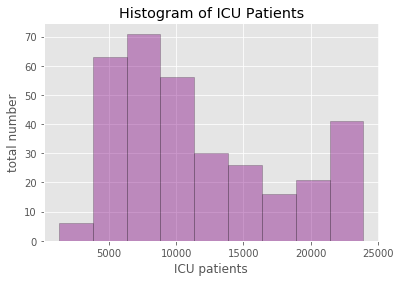

In [12]:
# histogram plot of ICU patients 
seaborn.distplot(final_covid_df['icu_patients'],kde=False, color = "purple", hist_kws={'edgecolor': 'black'}
                ).set(xlabel='ICU patients', ylabel= 'total number', title='Histogram of ICU Patients')
plt.show()

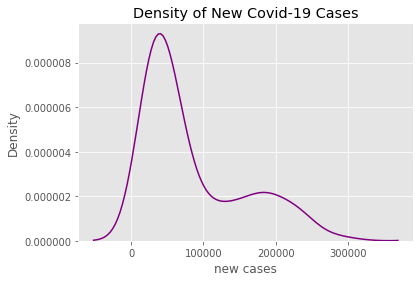

In [45]:
# density plot of new covid19 cases
seaborn.distplot(final_covid_df['new_cases'], hist = False, color = 'purple'
                ).set(title='Density of New Covid-19 Cases', ylabel='Density', xlabel='new cases')
plt.show()

## Model 2 Specifications
Let $y_i$ be the count of new covid-19 cases for day $i$ and let $c_i$ be the ICU patient count for day $i$. I assume that $y_i \sim \text{Bin}(N_i,\,\theta_i)$, which corresponds to $y_i$ the observed count of new covid-19 cases, out of a population of $N_i$ new covid-19 cases. The probability of observing a new covid-19 case is $\theta_i$. $N_i$ is not known. So, I assume that $N_i \sim \text{Pois}(\lambda_{i}c_i)$. To complete the model I assume that $\lambda_i \sim \text{Ga}(\alpha_\lambda\,,\beta_\lambda)$ and that $\theta_i \sim \text{Be}(1,\beta_\theta)$. Thus, the joint posterior is:
\begin{align*}
p(N_i,\lambda_i,\theta_i|y_i) &\propto \prod_{i=1}^n f(y_i|N_i,\theta_i)\, \pi(N_i|\lambda_{i}c_i)\, \pi(\lambda_i|\alpha_\lambda,\beta_\lambda)\,\pi(\theta_i|\beta_\theta) \\
&\propto \prod_{i=1}^n \frac{N_i!}{y_i!(N_i-y_i)!}\theta_i^{y_i}(1-\theta_i)^{N_i - y_i}\frac{(\lambda_{i}c_i)^{N_i}\text{exp}(-\lambda_{i} c_i) }{N_{i}!} \frac{\beta_{\lambda}^{\alpha_\lambda}}{\Gamma(\alpha_\lambda)}\lambda_{i}^{\alpha_\lambda - 1}\text{exp}(-\lambda_i \beta_\lambda)\frac{\theta_i^{1-1}(1-\theta_i)^{\beta_{\theta}-1}}{\text{B}(1,\beta_\theta)} \\
&\propto \prod_{i=1}^n \frac{1}{y_i!(N_i-y_i)!}\theta_i^{y_i}(1-\theta_i)^{N_i - y_i}(\lambda_{i}c_i)^{N_i}\text{exp}(-\lambda_{i} c_i) \lambda_{i}^{\alpha_\lambda - 1}\text{exp}(-\lambda_i \beta_\lambda)(1-\theta_i)^{\beta_{\theta}-1}
\end{align*}

From this, I obtain the full conditionals:
\begin{align*}
(N_i|\cdot) &\propto \frac{1}{(N_i - y_i) !}(1-\theta_i)^{N_i - y_i}(\lambda_i c_i)^{N_i} \\
&\\
(\lambda_i|\cdot) &\propto (\lambda_i c_i)^{N_i}\text{exp}(-\lambda_i c_i)\lambda_i^{\alpha_\lambda - 1}\text{exp}(-\lambda_i \beta_\lambda) \\
&\propto (\lambda_i)^{(N_i+\alpha_\lambda)-1}\text{exp}\left\{-\lambda_i(c_i + \beta_\lambda)\right\}\\
&\sim \text{Ga}(N_i+\alpha_\lambda,\,c_i + \beta_\lambda) \\
&\\
(\theta_i|\cdot) &\propto \theta_i^{y_i}(1-\theta_i)^{N_i - y_i}(1-\theta_i)^{\beta_\theta - 1}\\
&\propto \theta_i^{y_i}(1-\theta_i)^{N_i - y_i + \beta_\theta - 1}\\
&\sim \text{Be}(y_i,\, N_i - y_i + \beta_\theta)
\end{align*}

Note that the full conditional for $N_i|\cdot$ seems to follow a Poisson distribution with an offset. So our proposal density will follow a Poisson

In [6]:
def ln_factorial(n):
    # returns upper bound of sterlings approxiamtion
    upp_bound = n*np.log(n)
    return upp_bound

In [7]:
# define the natural log of the full conditional Ni
def Ni_ln_full_conditional(Ni, yi, ci, theta_i, lambda_i):
    return (-ln_factorial(Ni-yi) + (Ni)*np.log(1-theta_i) + Ni*np.log(lambda_i * ci))

In [8]:
def accept_prob_function(NewCond, CurrCond, NewProp, CurrProp):
    value = np.exp(NewCond - CurrCond) * np.exp(CurrProp - NewProp)
    return(value)

In [88]:
def metropolis_hastings(N_mcmc, yi, ci, a_lam, b_lam, b_theta):
    n = len(yi)
    
    # initialize your samples
    lambda_prior = np.random.gamma(shape = a_lam, scale = 1/b_lam, size = n)
    Ni_current_proposal = np.random.poisson(lam = lambda_prior*ci, size = n)
    
    lambda_i = np.zeros(shape = (N_mcmc,n) )
    theta_i = np.zeros(shape = (N_mcmc,n) )
    
    # Note Ni_samps will be our final Ni samples from the algorithm
    Ni_samps = np.zeros(shape = (N_mcmc,n))
    accept_prob = np.zeros(shape = n)
    count_accept = 0
    count_reject = 0
    
    for i in range(N_mcmc):
        # gibbin': iteratively update lambda_i, theta_i, Ni_new_proposal
        lambda_i[i,:] = np.random.gamma(shape = Ni_current_proposal + a_lam, scale = 1/(ci + b_lam), size = n)
        theta_i[i,:] = np.random.beta(a = yi, b = Ni_current_proposal - yi + b_theta, size = n)
        Ni_new_proposal = np.random.poisson(lam = lambda_i[i,:]*ci, size = n)
    
        # Metropolis-Hastings for Ni
        Ni_curr_full_conditional = Ni_ln_full_conditional(Ni_current_proposal, yi, ci, theta_i[i,:], lambda_i[i,:])
        Ni_new_full_conditional = Ni_ln_full_conditional(Ni_new_proposal, yi, ci, theta_i[i,:], lambda_i[i,:])
        
        Ni_curr_logpmf = poisson.logpmf(Ni_current_proposal, lambda_i[i,:]*ci, loc=0)
        Ni_new_logpmf = poisson.logpmf(Ni_new_proposal, lambda_i[i,:]*ci, loc=0)
    
        for j in range(n):
            accept_prob[j] = accept_prob_function(
                Ni_new_full_conditional.values[j], Ni_curr_full_conditional.values[j], 
                Ni_new_logpmf[j], Ni_curr_logpmf[j]
                )
            q = np.minimum(1, accept_prob[j])
            
            if np.random.uniform(0,1,1) <= q:
                        Ni_samps[i,j] = Ni_new_proposal[j]
                        count_accept = count_accept + 1    
            else: 
                        Ni_samps[i,j] = Ni_current_proposal[j]
                        count_reject = count_reject + 1
    
    return(lambda_i,theta_i, Ni_samps, accept_prob, count_reject, count_accept)

In [89]:
lambda_i,theta_i,Ni_samps, accept_prob, count_reject, count_accept = metropolis_hastings(N_mcmc = 4000, yi = final_covid_df['new_cases'],
                                                                                         ci = final_covid_df['icu_patients'], 
                                                                                         a_lam = 100, b_lam = .5, b_theta = .01)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  


In [90]:
#a_lam = 1000, b_lam = 2, b_theta = 2
# for numpy.delete(), axis= 0 implies row, 1 implies column
# obj: the row/column number 
posterior_lambda= np.delete(lambda_i, obj= range(2000), axis= 0)
posterior_theta= np.delete(theta_i, obj= range(2000), axis=0 )
posterior_Ni = np.delete(Ni_samps, obj= range(2000), axis=0)

print("Dimensions of Posterior Lambda: ", posterior_lambda)
# print("Dimensions of Posterior Thetha: ", posterior_theta.shape)
# print("Dimensions of Posterior Ni: ", posterior_Ni.shape)
# print("# accepted: ", count_accept)
# print("# rejected: ", count_reject)
#print("Acceptance Probability: ", accept_prob)

Dimensions of Posterior Lambda:  [[188.13950328 189.06048281 202.59076135 ... 193.34501478 215.57748836
  242.68769576]
 [187.6904273  189.17724208 202.39552522 ... 193.41628126 215.5762197
  242.29598449]
 [187.71902808 189.01839709 202.57815173 ... 193.38230213 215.41619342
  242.69262983]
 ...
 [187.81102268 189.70312542 202.04392814 ... 193.24688    215.14024174
  242.52821935]
 [187.5272586  189.63094255 202.69961858 ... 193.18149354 215.31508748
  242.6067276 ]
 [187.30116665 189.37734951 202.55636737 ... 193.51300009 215.42897887
  242.41842378]]


In [68]:
print(np.random.binomial(4000000,.006, size = 1))
print((final_covid_df['new_cases']).head())
# NI curr propos 1313421
# lambda i 1009.88
# ci 1299


[23840]
64    17856.0
65    18690.0
66    19630.0
67    18899.0
68    22075.0
Name: new_cases, dtype: float64


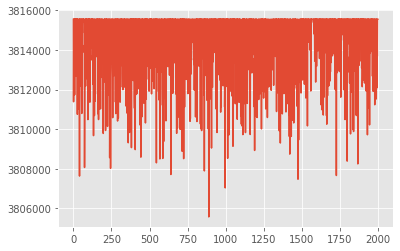

In [91]:
plt.plot(posterior_Ni[:,300])

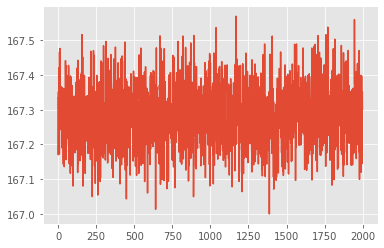

In [92]:
plt.plot(posterior_lambda[:,300])

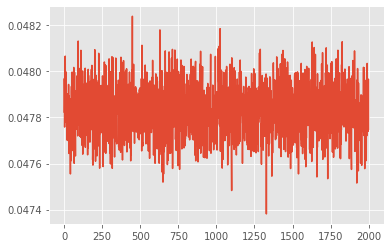

In [93]:
plt.plot(posterior_theta[:,300])